In [1]:
import pickle as pkl

import numpy as np
import pandas as pd
import torch.nn.functional as F

**Load data**

In [2]:
with open(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/model=slow-50-tap/model=slow-50_method=tap4x8_ext=manifold_mixup_triplets_feats.pkl",
    "rb",
) as f:
    data = pkl.load(f)

metadata = pd.read_csv(
    "/home/dl18206/Desktop/phd/data/panaf/PanAfFull/notebooks/data/panaf-seq_metadata.csv"
)

**Preprocess**

**Analyse a single video for subclip classifications**

In [3]:
behaviours = [
    "aggression",
    "bipedal",
    "camera_reaction",
    "climbing",
    "display",
    "feeding",
    "grooming",
    "object_carrying",
    "piloerection",
    "playing",
    "resting",
    "tool_use",
    "travel",
    "vocalisation",
]

behaviours_dict = {beh: i for i, beh in enumerate(behaviours)}

In [4]:
# Detach all tensors and move to CPU
for k, v in data.items():
    if k not in ["names"]:
        data[k] = v.detach().cpu()

In [5]:
# Apply softmax across all logits
logits = F.sigmoid(data["cas"])

logit_df = pd.DataFrame(
    logits.tolist(), columns=["clip_1", "clip_2", "clip_3", "clip_4"]
)

# Get the names of the clips
name_df = pd.DataFrame(data["names"], columns=["name"])
name_df = name_df.merge(
    metadata[["subject_id", "value"]], left_on="name", right_on="subject_id"
)

# Concatenate the two dataframes
df = pd.concat([name_df, logit_df], axis=1)

**How often can the sequence be recovered (via top-k)**

In [59]:


def can_recover_groundtruth(predictions, groundtruth_str, k, threshold=None):
    """
    Determine if the groundtruth sequence can be recovered from the predictions for the top-k predictions,
    considering temporal dynamics.

    Parameters:
    predictions (list of list of float): The multi-label predictions at each time step.
    groundtruth (list of int): The groundtruth sequence of labels.
    k (int): The value of k for top-k predictions.

    Returns:
    bool: True if the groundtruth sequence can be recovered, False otherwise.
    """

    groundtruth = []
    for behaviour in groundtruth_str.split(","):
        if behaviour in behaviours_dict.keys():
            groundtruth.append(behaviours_dict[behaviour])

    current_gt_index = 0
    n = len(groundtruth)

    for i in range(len(predictions)):

        # Apply thresholding to the predictions
        if threshold is not None:
            for p in predictions[i]:
                if p < threshold:
                    p = 0
                else:
                    continue

        # Get the top-k predictions for the current time step
        top_k_indices = np.argsort(predictions[i])[-k:]

        # Check if the current groundtruth label is in the top-k predictions
        if groundtruth[current_gt_index] in top_k_indices:
            # If we have matched all but the last groundtruth labels, break the loop
            if current_gt_index == n - 1:
                break
            else:
                current_gt_index += 1

    # Check the remaining predictions for the final groundtruth label
    remaining_predictions = False
    final_label = groundtruth[-1]
    for j in range(i + 1, len(predictions)):
        top_k_indices = np.argsort(predictions[j])[-k:]
        if final_label in top_k_indices:
            remaining_predictions = True
        else:
            remaining_predictions = False
    if remaining_predictions:
        return True

    # If we have not matched all groundtruth labels by the end of the predictions, return False
    return current_gt_index == n - 1 and final_label in np.argsort(predictions[-1])[-k:]

In [60]:
df

,name,subject_id,value,clip_1,clip_2,clip_3,clip_4,k_3,k_2,k_4
0,acp0000ecu.mp4,acp0000ecu.mp4,"travel,resting,camera_reaction,travel","[0.046186663210392, 0.1852106750011444, 0.3270...","[0.07149301469326019, 0.1631896197795868, 0.29...","[0.0522477813065052, 0.121314637362957, 0.2229...","[0.042595844715833664, 0.11403792351484299, 0....",False,False,True
1,acp0000eee.mp4,acp0000eee.mp4,"resting,camera_reaction","[0.03010391630232334, 0.0981057733297348, 0.14...","[0.03571592643857002, 0.10046136379241943, 0.1...","[0.03545587509870529, 0.11247675120830536, 0.2...","[0.03578083589673042, 0.08054041862487793, 0.1...",False,False,False
2,acp0000e8r.mp4,acp0000e8r.mp4,travel,"[0.06345184892416, 0.09627769887447357, 0.2039...","[0.016723252832889557, 0.023176632821559906, 0...","[0.0247979536652565, 0.02761819399893284, 0.08...","[0.01939476653933525, 0.024411600083112717, 0....",True,True,True
3,acp00007eo.mp4,acp00007eo.mp4,"camera_reaction,travel","[0.0386824868619442, 0.16975395381450653, 0.47...","[0.06159599497914314, 0.13529202342033386, 0.4...","[0.0425296388566494, 0.07538443058729172, 0.19...","[0.03838212043046951, 0.07555654644966125, 0.1...",True,True,True
4,acp000086v.mp4,acp000086v.mp4,"travel,bipedal,tool_use","[0.04103821888566017, 0.15715011954307556, 0.1...","[0.03897548094391823, 0.13457150757312775, 0.1...","[0.04791214317083359, 0.14926362037658691, 0.1...","[0.054878104478120804, 0.21589484810829163, 0....",False,False,False
...,...,...,...,...,...,...,...,...,...,...
579,acp0003r9n.mp4,acp0003r9n.mp4,"camera_reaction,tool_use,feeding","[0.04723763093352318, 0.08445605635643005, 0.1...","[0.027902331203222275, 0.05835343524813652, 0....","[0.00770807359367609, 0.025029562413692474, 0....","[0.020381931215524673, 0.052489057183265686, 0...",False,False,False
580,acp0003rks.mp4,acp0003rks.mp4,"tool_use,resting","[0.007024955004453659, 0.03658457472920418, 0....","[0.004270737990736961, 0.023907851427793503, 0...","[0.009194358251988888, 0.03865706920623779, 0....","[0.02427278831601143, 0.06765443831682205, 0.2...",True,True,True
581,acp0003v8o.mp4,acp0003v8o.mp4,"object_carrying,travel","[0.011366123333573341, 0.03467094153165817, 0....","[0.012300258502364159, 0.03668038919568062, 0....","[0.019471727311611176, 0.05068722367286682, 0....","[0.017399780452251434, 0.044091664254665375, 0...",False,False,False
582,acp0003szl.mp4,acp0003szl.mp4,"object_carrying,tool_use","[0.003431620541960001, 0.05847429484128952, 0....","[0.002916986821219325, 0.06053123250603676, 0....","[0.003773113014176488, 0.03959934040904045, 0....","[0.003302965546026826, 0.05218345299363136, 0....",True,False,True


In [50]:
# Top-2
df["k_2"] = df.apply(
    lambda x: can_recover_groundtruth(
        x[["clip_1", "clip_2", "clip_3", "clip_4"]], x["value"], k=2, threshold=0.1
    ),
    axis=1,
)

# Top-3
df["k_3"] = df.apply(
    lambda x: can_recover_groundtruth(
        x[["clip_1", "clip_2", "clip_3", "clip_4"]], x["value"], k=3, threshold=0.1
    ),
    axis=1,
)

# Top-3
df["k_4"] = df.apply(
    lambda x: can_recover_groundtruth(
        x[["clip_1", "clip_2", "clip_3", "clip_4"]], x["value"], k=4, threshold=0.1
    ),
    axis=1,
)

In [58]:
print(df.k_2.value_counts(normalize=True))
print(df.k_3.value_counts(normalize=True))
print(df.k_4.value_counts(normalize=True))

True     0.55137
False    0.44863
Name: k_2, dtype: float64
True     0.695205
False    0.304795
Name: k_3, dtype: float64
True     0.785959
False    0.214041
Name: k_4, dtype: float64


In [51]:
def get_dist(values):
    all_values = []
    split_values = [x.split(",") for x in values]
    for i in split_values:
        for j in i:
            all_values.append(j)
    pd.DataFrame(all_values, columns=["behaviour"]).value_counts().plot(kind="bar")

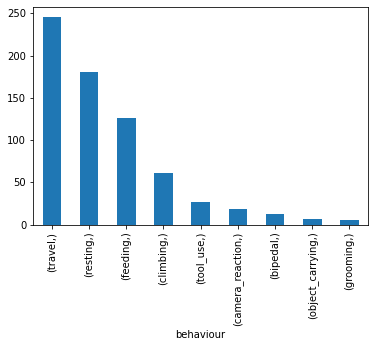

In [48]:
get_dist(df[df.k_3 == True]["value"])

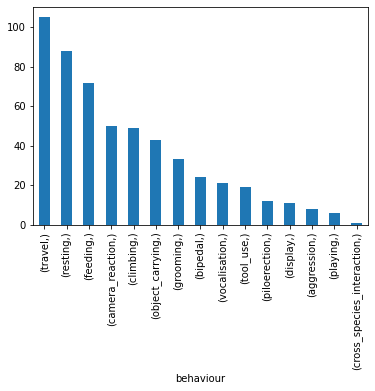

In [49]:
get_dist(df[df.k_3 == False]["value"])